In [28]:
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf


In [29]:


emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def parse_ravdess(root_dir, modality_label):
    """
    Parses RAVDESS directory and extracts metadata from filenames.

    Args:
        root_dir (str): Path to RAVDESS dataset directory.
        modality_label (str): 'speech' or 'song' for classification.

    Returns:
        pd.DataFrame: DataFrame containing file metadata.
    """
    data = []

    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith(".wav"):
                # Split metadata
                parts = file.split("-")
                emotion_code = parts[2]
                actor = int(parts[-1].split(".")[0])

                # Map emotion code to label
                emotion = emotion_map.get(emotion_code, "unknown")

                data.append({
                    "filepath": os.path.join(dirpath, file),
                    "emotion_code": emotion_code,
                    "emotion": emotion,
                    "actor": actor,
                    "modality": modality_label
                })

    return pd.DataFrame(data)


combine both song and speech data into one dataset

In [30]:
# Parse both folders
df_speech = parse_ravdess("D:\\study\\sem5\\Summer\\MaRS\\Audio_Speech_Actors_01-24", "speech")
df_song = parse_ravdess("D:\\study\\sem5\\Summer\\MaRS\\Audio_Song_Actors_01-24", "song")

# Combine
df_all = pd.concat([df_speech, df_song], ignore_index=True)

# Preview
df_all.tail(7)


,filepath,emotion_code,emotion,actor,modality
2445,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song
2446,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song
2447,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song
2448,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song
2449,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song
2450,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song
2451,D:\study\sem5\Summer\MaRS\Audio_Song_Actors_01...,06,fearful,24,song


In [31]:
df_all['emotion'].value_counts()


emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64

In [32]:
df_all['modality'].value_counts()


modality
speech    1440
song      1012
Name: count, dtype: int64

In [33]:
df_all.isnull().sum()


filepath        0
emotion_code    0
emotion         0
actor           0
modality        0
dtype: int64

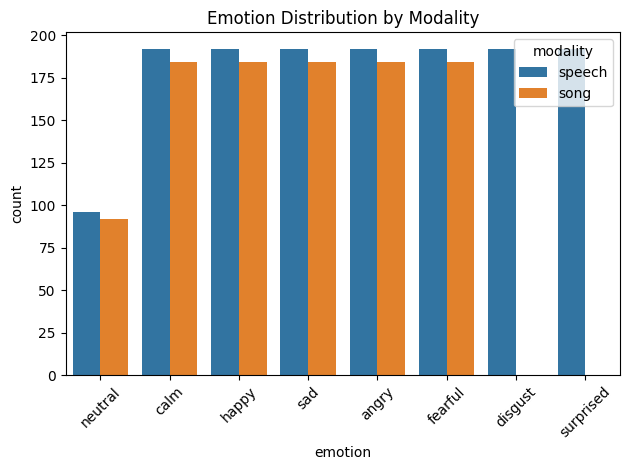

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_all, x='emotion', hue='modality')
plt.title("Emotion Distribution by Modality")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


neutral class is imbalanced 

disgust and surprised class does not have any instance in song modality



------------------------


This is the core function that processes a single .wav file into a fixed-size feature matrix.

Inputs:
file_path: Path to the audio file.

sr=22050: Target sampling rate. Default is 22.05 kHz.

n_mfcc=40: Number of MFCCs to extract.

max_pad_len=200: The number of time steps to which the sequence will be padded or truncated.

Steps:
Load audio using librosa.load() (resampled to sr=22050).

Extract MFCCs using librosa.feature.mfcc(...), returning a matrix of shape (n_mfcc, time_steps), then transpose to (time_steps, n_mfcc).

Pad or truncate:

If time_steps > 200, truncate to the first 200.

If time_steps < 200, pad with zeros.

Else, return as-is.

In [35]:
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm # For progress bar

# Define a function to extract sequence features
def extract_sequence_features(file_path, sr=22050, n_mfcc=40, max_pad_len=200):
    """
    Extracts MFCCs (or other time-series features) from an audio file and pads/truncates them.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)

        # Extract MFCCs (most common for RNNs)
        # Transpose to (time_steps, n_mfcc)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T


        # Pad or truncate the sequence to a fixed length
        if mfccs.shape[0] > max_pad_len:
            padded_mfccs = mfccs[:max_pad_len, :]
        elif mfccs.shape[0] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[0]
            padded_mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        else:
            padded_mfccs = mfccs

        return padded_mfccs

    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# --- Main Feature Extraction Loop ---
all_features_sequences = []
all_labels = []

# Define parameters for feature extraction
SAMPLE_RATE = 22050 # Common sample rate
N_MFCC = 40         # Number of MFCCs
MAX_PAD_LEN = 200   # Max sequence length for padding/truncation

# Iterate through your df_all DataFrame
for index, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Extracting sequence features"):
    file_path = row['filepath']
    emotion_label = row['emotion']

    # Check if the file exists before processing
    if not os.path.exists(file_path):
        # print(f"Warning: File not found: {file_path}. Skipping.")
        continue # Skip to the next file

    features_sequence = extract_sequence_features(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN)

    if features_sequence is not None:
        all_features_sequences.append(features_sequence)
        all_labels.append(emotion_label)

# Convert to numpy arrays
features_np_seq = np.array(all_features_sequences)
labels_np = np.array(all_labels)

print(f"Shape of extracted features (sequences): {features_np_seq.shape}")
print(f"Shape of extracted labels: {labels_np.shape}")

# Example: (Number of samples, Max Sequence Length, Number of MFCCs)
# E.g., (1000, 200, 40)

Extracting sequence features: 100%|████████████████████████████████████████████████| 2452/2452 [01:33<00:00, 26.09it/s]

Shape of extracted features (sequences): (2452, 200, 40)
Shape of extracted labels: (2452,)


### Below code prepares the MFCC feature dataset and emotion labels for training a neural network 

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical

# 1. Encode Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_np)
categorical_labels = to_categorical(encoded_labels)

# Get the number of emotion categories
num_classes = len(label_encoder.classes_)
print(f"Number of emotion classes: {num_classes}")

# 2. Split Data
# X is features_np_seq (num_samples, max_pad_len, n_mfcc)
# y is categorical_labels (num_samples, num_classes)
X_train, X_test, y_train, y_test = train_test_split(
    features_np_seq, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels
)

# 3. Feature Scaling (Crucial for numerical stability of neural networks)
# Scaler expects (n_samples, n_features). Our data is (samples, timesteps, features).
# We need to reshape for scaling, then reshape back.
original_shape_train = X_train.shape
original_shape_test = X_test.shape

# Reshape X_train and X_test from (samples, timesteps, features) to (samples * timesteps, features)
X_train_reshaped_for_scaling = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped_for_scaling = X_test.reshape(-1, X_test.shape[-1])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped_for_scaling)
X_test_scaled = scaler.transform(X_test_reshaped_for_scaling)

# Reshape back to original 3D shape (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape(original_shape_train)
X_test_scaled = X_test_scaled.reshape(original_shape_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Number of emotion classes: 8
X_train_scaled shape: (1961, 200, 40)
X_test_scaled shape: (491, 200, 40)
y_train shape: (1961, 8)
y_test shape: (491, 8)


### Below code define, compile, and train a deep neural network for speech emotion recognition using Bidirectional LSTM + GRU + Attention,
 
#### and they include mechanisms to improve generalization and training stability

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D # Added GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
print(f"Model input shape: {input_shape}")

# Model Definition
def build_rnn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTMs are often effective for sequential data
    # return_sequences=True is crucial for passing sequences to the Attention layer
    rnn_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(inputs)
    rnn_out = Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(rnn_out)

    # Attention Layer
    attention_output = Attention()([rnn_out, rnn_out])

    attended_representation = GlobalAveragePooling1D()(attention_output)

    # Dense Layers for Classification
    dense_1 = Dense(128, activation='relu')(attended_representation)
    dropout_1 = Dropout(0.4)(dense_1)
    output = Dense(num_classes, activation='softmax')(dropout_1)

    model = Model(inputs=inputs, outputs=output)
    return model

# Create the model
model = build_rnn_attention_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model input shape: (200, 40)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200, 40)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 200, 256)          │         173,056 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 200, 256)          │         296,448 │ bidirectional[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 200, 256)          │               0 │ bidirectional_1[0][0],     │
│                               │                           │                 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 256)               │               0 │ attention[0][0]            │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          32,896 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 8)                 │           1,032 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 503,432 (1.92 MB)

 Trainable params: 503,432 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=30, # You can adjust this
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.2505 - loss: 1.8997 - val_accuracy: 0.4725 - val_loss: 1.3243 - learning_rate: 0.0010
Epoch 2/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 687s 3s/step - accuracy: 0.4293 - loss: 1.4737 - val_accuracy: 0.5458 - val_loss: 1.1394 - learning_rate: 0.0010
Epoch 3/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 939s 4s/step - accuracy: 0.4979 - loss: 1.3244 - val_accuracy: 0.5743 - val_loss: 1.0816 - learning_rate: 0.0010
Epoch 4/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 912s 4s/step - accuracy: 0.5280 - loss: 1.2051 - val_accuracy: 0.6415 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 5/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 937s 4s/step - accuracy: 0.5809 - loss: 1.1124 - val_accuracy: 0.6680 - val_loss: 0.9206 - learning_rate: 0.0010
Epoch 6/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.6169 - loss: 1.0213 - val_accuracy: 0.6375 - val_loss: 0.9459 - learning_rate: 0.0010
Epoch 7/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.6412 - loss: 0.

Test Loss: 0.5068
Test Accuracy: 0.8310
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.80      0.86        75
        calm       0.88      0.92      0.90        75
     disgust       0.76      0.87      0.81        39
     fearful       0.80      0.80      0.80        75
       happy       0.90      0.80      0.85        75
     neutral       0.78      0.84      0.81        38
         sad       0.78      0.79      0.78        75
   surprised       0.77      0.87      0.82        39

    accuracy                           0.83       491
   macro avg       0.82      0.84      0.83       491
weighted avg       0.84      0.83      0.83       491



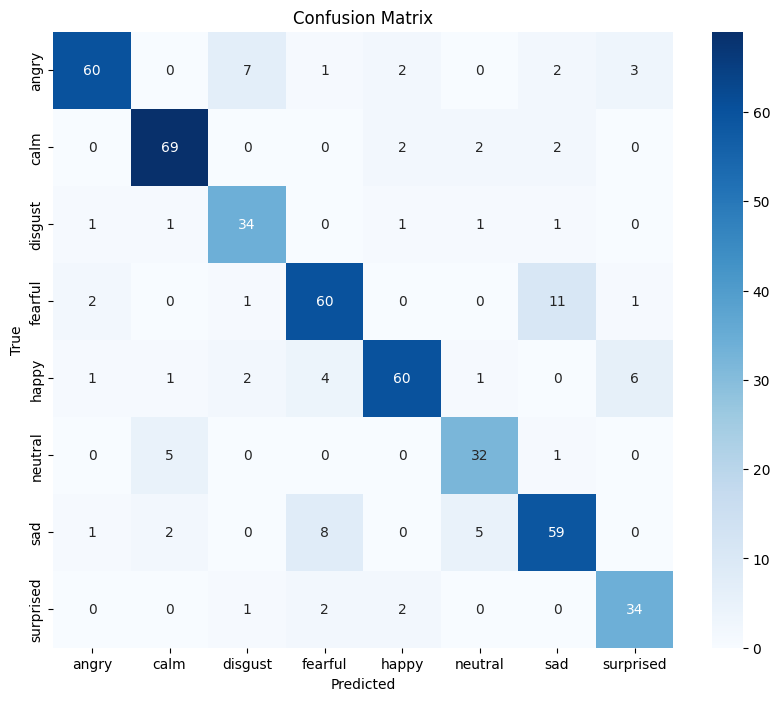

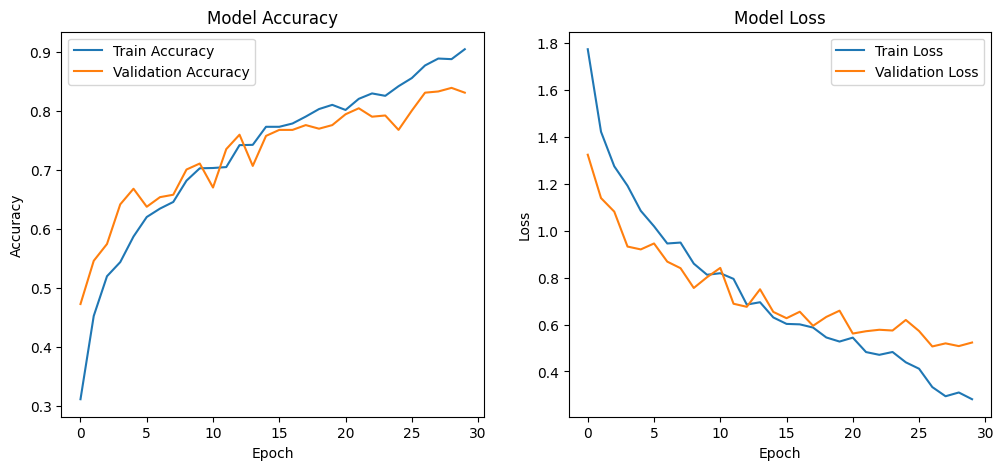

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Above are the result of model on validation dataset
#### overall accuracy is 0.831 (>0.8)
#### F1 score 0.83 (>0.8 )


Per-Class Metrics:
angry: Accuracy = 0.8000, F1 Score = 0.8571
calm: Accuracy = 0.9200, F1 Score = 0.9020
disgust: Accuracy = 0.8718, F1 Score = 0.8095
fearful: Accuracy = 0.8000, F1 Score = 0.8000
happy: Accuracy = 0.8000, F1 Score = 0.8451
neutral: Accuracy = 0.8421, F1 Score = 0.8101
sad: Accuracy = 0.7867, F1 Score = 0.7815
surprised: Accuracy = 0.8718, F1 Score = 0.8193


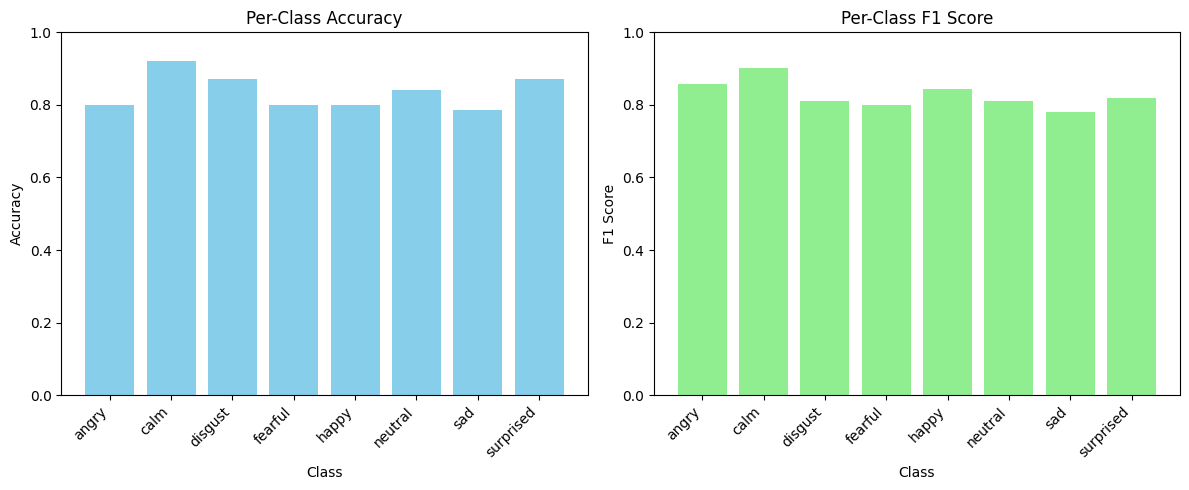

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

# Assuming the provided code has already run, so y_true, y_pred, cm, and label_encoder are defined

# Step 1: Compute per-class accuracy from confusion matrix
# Per-class accuracy = diagonal element / row sum (correct predictions / total samples per class)
class_names = label_encoder.classes_  # Class names (e.g., ['happy', 'sad', 'angry', 'neutral'])
num_classes = len(class_names)
per_class_accuracy = np.zeros(num_classes)
for i in range(num_classes):
    if cm[i].sum() > 0:  # Avoid division by zero if a class has no samples
        per_class_accuracy[i] = cm[i,i] / cm[i].sum()
    else:
        per_class_accuracy[i] = 0.0

# Step 2: Get F1 scores from classification_report
# Use output_dict=True to get metrics as a dictionary
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
per_class_f1 = np.zeros(num_classes)
for i, class_name in enumerate(class_names):
    per_class_f1[i] = report[class_name]['f1-score']

# Step 3: Print per-class accuracy and F1 score
print("\nPer-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: Accuracy = {per_class_accuracy[i]:.4f}, F1 Score = {per_class_f1[i]:.4f}")

# Step 4: Plot per-class accuracy and F1 score
plt.figure(figsize=(12, 5))

# Bar plot for per-class accuracy
plt.subplot(1, 2, 1)
plt.bar(class_names, per_class_accuracy, color='skyblue')
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Bar plot for per-class F1 score
plt.subplot(1, 2, 2)
plt.bar(class_names, per_class_f1, color='lightgreen')
plt.title('Per-Class F1 Score')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### for every class accuracy is (>0.8)

In [44]:
model.save("model/emotionn_modell.h5")
